# Clustering of the VAE latent space for anomaly detection of diverse time-series sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [325]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix

In [3]:
from IPython.core.debugger import set_trace

In [4]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / 'src'))

from clustering import *
device

device(type='cuda', index=0)

In [5]:
desc

'accumulator'

In [6]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [7]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 14.268
Epoch: 210


Next we need to load the datasets of sensors readings.

In [8]:
data_path = Path(f'../data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [9]:
print(len(train_dl), len(val_dl), len(test_dl))

27 7 1157


Run model on training set combined with validation set to get latent vectors to use for building clustering model.

In [10]:
train_latents, targets = compute_latents(train_dl, model)
assert np.all(targets == 0), 'Invalid training data - faults present'
print(train_latents.shape)

100%|██████████| 27/27 [00:04<00:00,  5.83it/s]

(839, 50)


In [11]:
val_latents, targets = compute_latents(val_dl, model)
assert np.all(targets == 0), 'Invalid training data - faults present'
print(val_latents.shape)

100%|██████████| 7/7 [00:01<00:00,  5.51it/s]

(209, 50)


In [12]:
latents = np.vstack([train_latents, val_latents])
print(latents.shape)

(1048, 50)


To evaluate the hyperparameter I want to minimize the information criterion as a measure of model efficiency. I prefer the bayesian version over akaike for this because it penalizes complex models more. My intuition is that a simpler clustering will perform better for general cases.

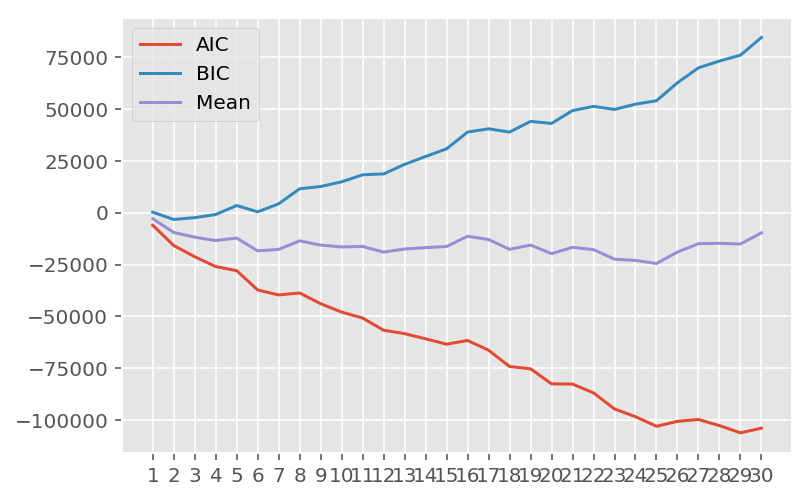

In [371]:
# Select model based on lowest BIC score
n_range = range(1, 31)
aic = np.zeros(len(n_range))
bic = np.zeros(len(n_range))
for i, n in enumerate(n_range):
    gmm = GaussianMixture(n_components=n,
                          covariance_type='full',
                          random_state=0)
    gmm = gmm.fit(train_latents)
    aic[i] = gmm.aic(train_latents)
    bic[i] = gmm.bic(train_latents)
plt.plot(n_range, aic, label="AIC")
plt.plot(n_range, bic, label='BIC')
mic = np.stack([aic, bic]).mean(axis=0)
plt.plot(n_range, mic, label='Mean')
plt.xticks(n_range)
plt.legend()

In [403]:
# Select hyperparameter that minimizes mean of AIC and BIC
n = n_range[np.argmin(mic)]
n = min(n, 10)
n

10

In [404]:
# Fit GMM model
gmm = GaussianMixture(n_components=n,
                      covariance_type='full',
                      random_state=0)
gmm = gmm.fit(latents)

PCA can be used to visualize the clustering of the training data.

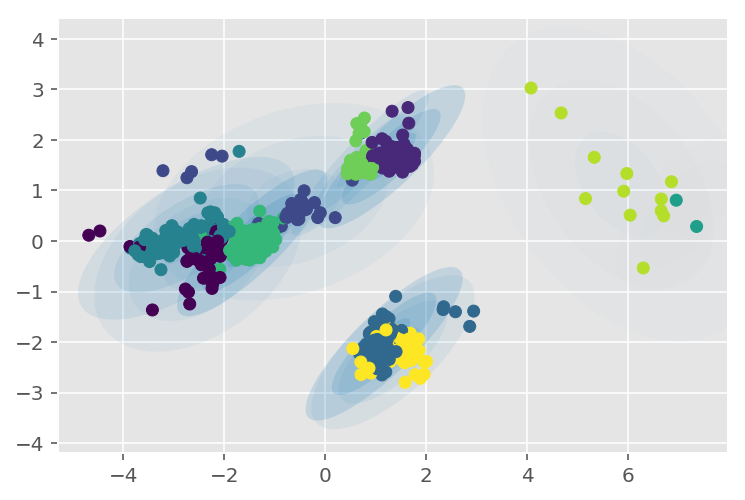

In [405]:
# Project to 2D for plotting
plot_clusters(train_latents, gmm)

Let's calculate probabilities on the test dataset to look for an outlier threshold.

In [406]:
# Use the test set with the anomaly labels as targets
test_latents, targets = compute_latents(test_dl, model)
print(test_latents.shape)
for i, c in enumerate(test_dl.dataset.classes):
    print(f'Target {i} ({c}) = {(targets == i).sum()} samples')

100%|██████████| 1157/1157 [00:07<00:00, 149.55it/s]

(1157, 50)
Target 0 (fail) = 808 samples
Target 1 (norm) = 349 samples


In [430]:
log_probs = calculate_log_probs(test_latents, gmm)
log_probs.shape

(1157,)

In [431]:
# Average normal log prob
log_probs[targets == 1].mean()

-85.39709151544494

In [432]:
# Average fault log prob
log_probs[targets == 0].mean()

-1608.9632900014415

We're on the right track here. The anomalies have a lower log probability on average and the seperation looks to be much better than with MSE. Lets compare the histograms and dive into the accuracy metrics on the test dataset.

In [433]:
normal_logp = log_probs[targets == 1]
print('Normal')
print('95% =', np.percentile(normal_logp, 95))
print('75% =', np.percentile(normal_logp, 75))
print('50% =', np.percentile(normal_logp, 50))
print('25% =', np.percentile(normal_logp, 25))
print('5% =', np.percentile(normal_logp, 5))
print('Samples:', normal_logp.size)

Normal
95% = 47.11679827112553
75% = 35.11174714142028
50% = 21.939122974601204
25% = -2.3808229723834557
5% = -374.45973989271107
Samples: 349


In [434]:
anomaly_logp = log_probs[targets == 0]
print('Anomaly')
print('95% =', np.percentile(anomaly_logp, 95))
print('75% =', np.percentile(anomaly_logp, 75))
print('50% =', np.percentile(anomaly_logp, 50))
print('25% =', np.percentile(anomaly_logp, 25))
print('5% =', np.percentile(anomaly_logp, 5))
print('Samples:', anomaly_logp.size)

Anomaly
95% = 32.31560257604101
75% = 1.692088502829371
50% = -77.35539448256456
25% = -709.6534923528816
5% = -7113.356958384638
Samples: 808


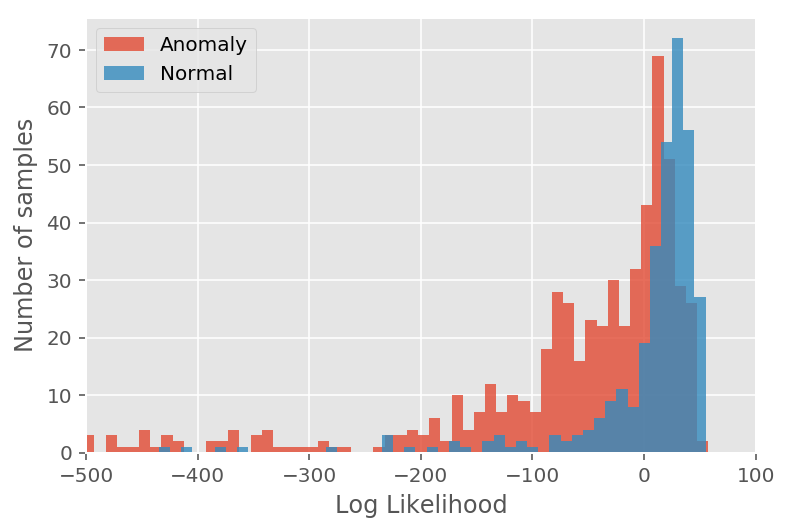

In [435]:
bin_w = 10
plt.hist(anomaly_logp, label='Anomaly', alpha=0.8,
         bins=np.arange(anomaly_logp.min(), anomaly_logp.max() + bin_w, bin_w))
plt.hist(normal_logp, label='Normal', alpha=0.8,
         bins=np.arange(normal_logp.min(), anomaly_logp.max() + bin_w, bin_w))
plt.xlabel('Log Likelihood')
plt.ylabel('Number of samples')
plt.xlim([-500, 100])
plt.legend()

In [436]:
min_threshold = np.percentile(normal_logp, 5)
max_threshold = np.percentile(normal_logp, 99)
thresholds = np.linspace(min_threshold, max_threshold, 1000)

f1_scores = np.zeros(thresholds.size)
auc_scores = np.zeros(thresholds.size)
acc_scores = np.zeros(thresholds.size)

for i, threshold in enumerate(thresholds):
    anomalies = log_probs < threshold
    # Must invert targets because fault=0
    f1_scores[i] = f1_score(1 - targets, anomalies)
    auc_scores[i] = roc_auc_score(1 - targets, anomalies)
    acc_scores[i] = accuracy_score(1 - targets, anomalies)

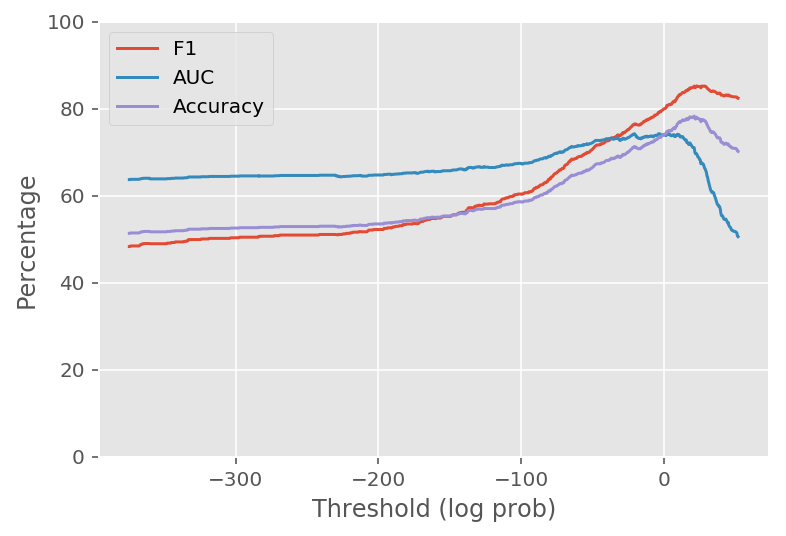

In [437]:
plt.plot(thresholds, 100 * f1_scores, label='F1')
plt.plot(thresholds, 100 * auc_scores, label='AUC')
plt.plot(thresholds, 100 * acc_scores, label='Accuracy')
plt.ylim([0, 100])
plt.ylabel('Percentage')
plt.xlabel('Threshold (log prob)')
plt.legend()

In [438]:
# Max scores
print('Max scores: {:.2%}, {:.2%}, {:.2%}'.format(acc_scores.max(), f1_scores.max(), auc_scores.max()))

Max scores: 78.31%, 85.25%, 74.25%


In [439]:
best_thresholds = [thresholds[np.argmax(acc_scores)],
                   thresholds[np.argmax(f1_scores)],
                   thresholds[np.argmax(auc_scores)]]
print('Best thresholds: {:.3f}, {:.3f}, {:.3f}'.format(*best_thresholds))
print('Average: {:.3f}'.format(np.mean(best_thresholds)))

Best thresholds: 21.292, 23.000, -20.546
Average: 7.915


It is necessary to select a threshold without access to labelled target data. The F1 threshold appears to be a good choice because it balances true and false positives. Ultimately the end user would have some control over the threshold if nuisance faults were a problem.

Text(0.5,0,'False Positive Rate')

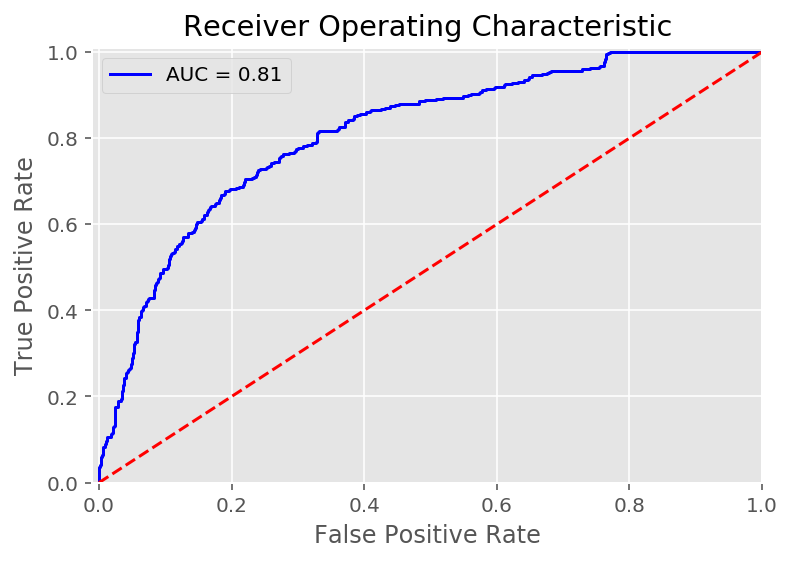

In [440]:
# Plot the ROC curve for visualization of model performance
fpr, tpr, roc_thresholds = roc_curve(targets, log_probs)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label=f'AUC = {auc(fpr, tpr):0.2f}')
plt.legend()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

As a final confirmation of the approach I want to check the metrics on the validation dataset alone. Ideally all would classify as normal.

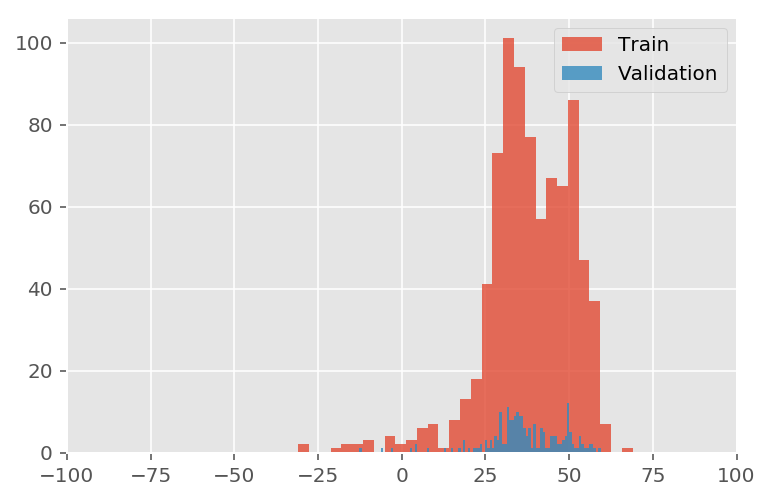

In [441]:
# Calculate log probabilities on training set
train_probs = calculate_log_probs(train_latents, gmm)
val_probs = calculate_log_probs(val_latents, gmm)

# Plot histogram to find reasonable thresholds
plt.hist(train_probs, bins=100, label='Train', alpha=0.8)
plt.hist(val_probs, bins=100, label='Validation', alpha=0.8)
plt.xlim([-100, 100])
plt.legend()

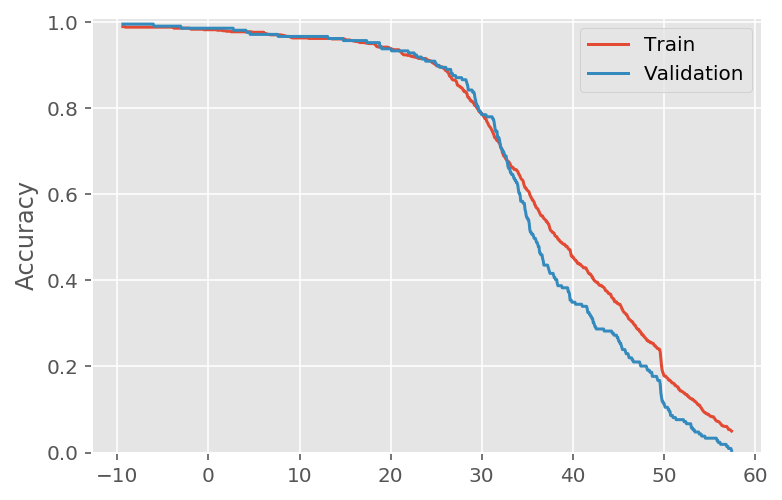

In [442]:
# Sweep thresholds and calculate metrics
min_threshold = np.percentile(train_probs, 1)
max_threshold = np.percentile(train_probs, 95)
thresholds = np.linspace(min_threshold, max_threshold, 1000)

train_targets = np.zeros(train_probs.shape[0])
val_targets = np.zeros(val_probs.shape[0])

train_acc_scores = np.zeros(thresholds.size)
val_acc_scores = np.zeros(thresholds.size)

for i, threshold in enumerate(thresholds):
    anomalies = train_probs < threshold
    train_acc_scores[i] = accuracy_score(train_targets, anomalies)
    
    anomalies = val_probs < threshold
    val_acc_scores[i] = accuracy_score(val_targets, anomalies)

# Plot performance
plt.plot(thresholds, train_acc_scores, label='Train')
plt.plot(thresholds, val_acc_scores, label='Validation')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend()

In [443]:
# For comparison the training percentiles
print('Training Percentiles')
for p in range(5, 96, 10):
    print(f'{p}% = ', np.percentile(train_probs, p))

Training Percentiles
5% =  18.130137363726632
15% =  27.637973661716376
25% =  31.07271282164117
35% =  33.999267992722906
45% =  36.58668631207579
55% =  40.17072998949216
65% =  44.73960437142437
75% =  48.92743641710782
85% =  51.575142818040185
95% =  57.433394556015465


In [444]:
# And the validation percentiles
print('Validation Percentiles')
for p in range(5, 96, 10):
    print(f'{p}% = ', np.percentile(val_probs, p))

Validation Percentiles
5% =  18.805200722804226
15% =  28.480503551912342
25% =  31.519718227375677
35% =  33.2245681980836
45% =  34.92176965584142
55% =  36.68621006394265
65% =  39.94443241001265
75% =  45.2944234712364
85% =  49.629033269777665
95% =  53.29027754158499


A decent strategy for initializing the threshold is to set it at the 10th percentile of the training log probabilities.

In [445]:
threshold = np.percentile(train_probs, 10)
threshold

25.037018689367205

In [446]:
# Sanity check validation accuracy using this threshold, should be around 90%
corr = (val_probs >= threshold).sum()
count = val_probs.size
print(f"Validation accuracy = {corr}/{count} ({corr / count:.2%})")

Validation accuracy = 188/209 (89.95%)


In [447]:
# On the test set our accuracy would be...
anomalies = (log_probs < threshold)
print(f"Test accuracy = {accuracy_score(1 - targets, anomalies):.2%}")
print(f"Test F1 score = {f1_score(1 - targets, anomalies):.2%}")

Test accuracy = 77.53%
Test F1 score = 85.06%


Text(0.5,15,'Predicted')

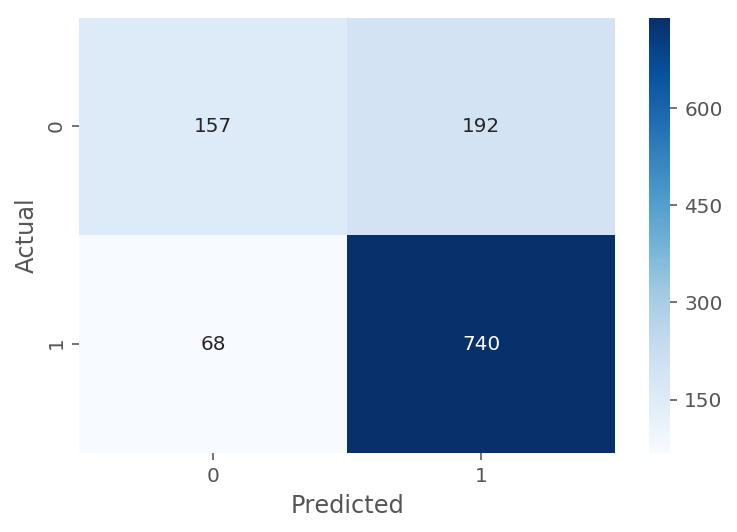

In [448]:
# Test set confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(1 - targets, anomalies),
            annot=True, cmap='Blues', fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Save the means and covariances of the clusters and the threshold.

In [449]:
np.save(Path(f'../models/{date}-{desc}/cluster_means.npy'), gmm.means_)
np.save(Path(f'../models/{date}-{desc}/cluster_covars.npy'), gmm.covariances_)
np.save(Path(f'../models/{date}-{desc}/threshold.npy'), threshold)